In [7]:

import pandas as pd
import numpy as np
import nbimporter
import feature_engineering
from datetime import datetime, timedelta
from functools import reduce
import glob
import os
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

warnings.simplefilter(action='ignore', category=FutureWarning)

# 1. Preprocessing

In [8]:
%run Preprocessing.ipynb

## 1.1 Climate Data

### 1.1.1 Climate Data - Import 

In [9]:
climate_data = ["Temperature", "Precipitation"]
station_names = ["Berlin", "BW", "NRW"]
current_directory = os.getcwd()
temp_path = rf"{current_directory}\Wetter"
file_name = "produkt*"
date_column = "MESS_DATUM"
date_format = '%Y%m%d%H%M'

station_climate_list = []

for station in station_names:
    for data in climate_data:
        file_path =rf"{temp_path}\{station}\{data}"
        #print(file_path)
        temperature_dic = importing_climate_data(file_path, file_name, date_column, date_format)
        #print(temperature_dic)
        station_climate_list.append(temperature_dic)

print("done")

done


### 1.1.2 Climate Data - Downsampling to 15min steps

In [10]:
climate_resampled = []
for station in station_climate_list:
    resampled_dic = resampling_data(station, "15T")
    climate_resampled.append(resampled_dic)


print("done")

done


## 1.2 Football Data

### 1.2.1 Football Data - Importing

In [11]:

temp_path =r"Spielplan"
file_name = "*.csv"
date_column = "DateTime"
date_format = '%d. %b %y %H:%M'
other_date_format = '%d.%m.%Y %H:%M'



football_dic = importing_football_data(temp_path, file_name, date_column, date_format, other_date_format)
print("done")

    

done


### 1.2.2 Football Data - Adding new columns for Matches at same time

In [12]:

football_dic_new = {}
for key, match_set in football_dic.items():

    results = new_col_match(match_set)        
        
    results.set_index("DateTime")
    football_dic_new[key] = results

print("done")

             DateTime    Land1        Land2         Runde Liga       Land3  \
0 2024-06-23 21:00:00  Schweiz  Deutschland  Gruppenphase   EM  Schottland   

    Land4  
0  Ungarn  
          Land1        Land2         Runde Liga            DateTime  \
0   Deutschland   Schottland  Gruppenphase   EM 2024-06-14 21:00:00   
1        Ungarn      Schweiz  Gruppenphase   EM 2024-06-15 15:00:00   
2       Spanien     Kroatien  Gruppenphase   EM 2024-06-15 18:00:00   
3       Italien     Albanien  Gruppenphase   EM 2024-06-15 21:00:00   
4         Polen  Niederlande  Gruppenphase   EM 2024-06-16 15:00:00   
5     Slowenien     Dänemark  Gruppenphase   EM 2024-06-16 18:00:00   
6       Serbien      England  Gruppenphase   EM 2024-06-16 21:00:00   
7      Rumänien      Ukraine  Gruppenphase   EM 2024-06-17 15:00:00   
8       Belgien     Slowakei  Gruppenphase   EM 2024-06-17 18:00:00   
9    Österreich   Frankreich  Gruppenphase   EM 2024-06-17 21:00:00   
10       Türkei     Georgien  Gruppenp

## 1.3 Electricity Data

### 1.3.1 Electricity Data - Importing and converting MWh to floats

In [13]:
temp_path =r"Stromverbrauch\Viertel"
file_name = "*.csv"
date_column = "Datum von"
date_format = "%d.%m.%Y %H:%M"

elec_dic = importing_electricity_data(temp_path, file_name, date_column, date_format)



## 1.4 Merging Dataframes, dropping unwanted columns, filling nans with during match with data from football dataset

In [14]:
dfs = []

unwantend_col_string = ["QN", "MESS_DATUM", 'Datum von', 'Datum bis', "eor", "STATIONS"]
#print(climate_resampled)
for key, elec in elec_dic.items():
    football = football_dic_new[key]
    electricity = elec
    climate_data = []
    for station in climate_resampled:
        climate_data.append(pd.DataFrame(station[key])) 

    merged_df = merging_data(electricity, football, climate_data, unwantend_col_string)
                       
    dfs.append(merged_df)

endresult_df = pd.concat(dfs, ignore_index = True)

print("done")


done


# 2. Feature Engineering

In [15]:
%run feature_engineering.ipynb

## 2.1 Correlation matrix

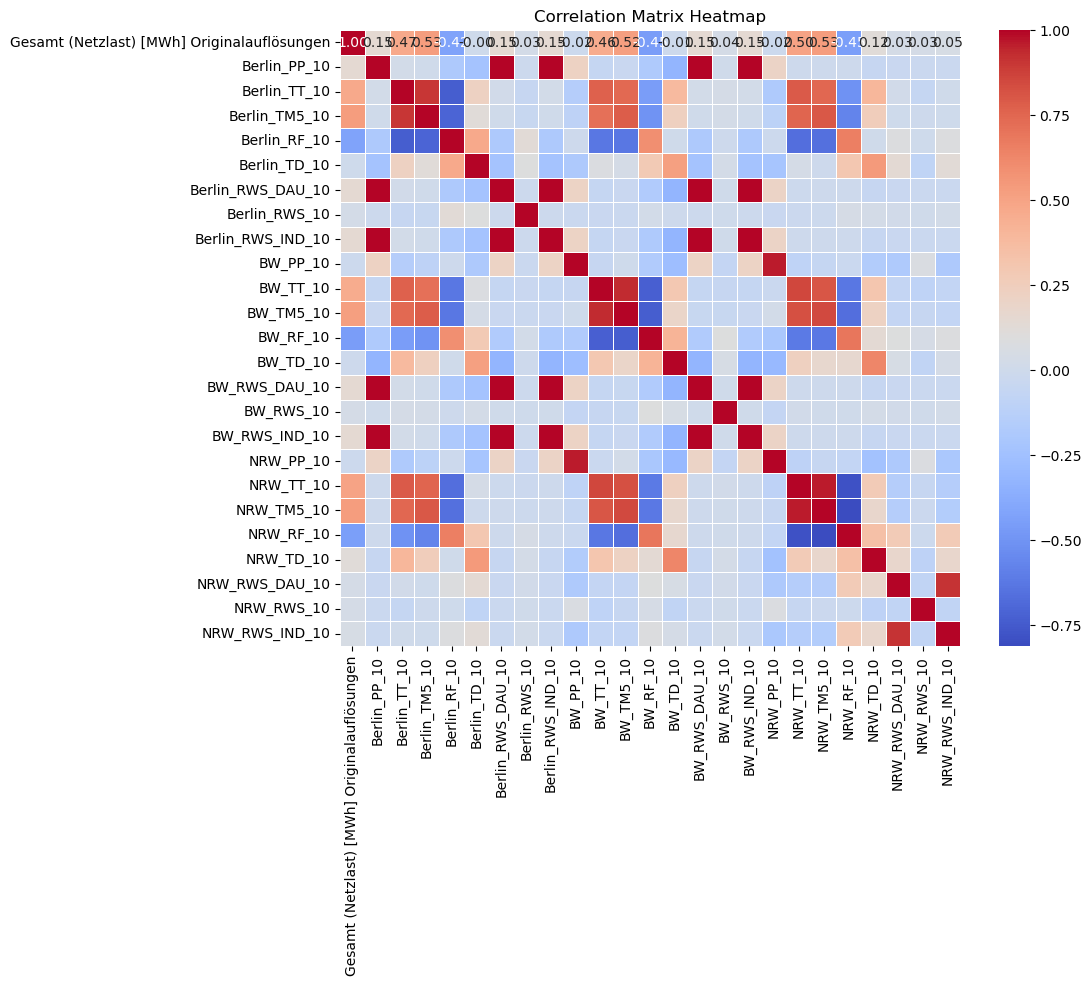

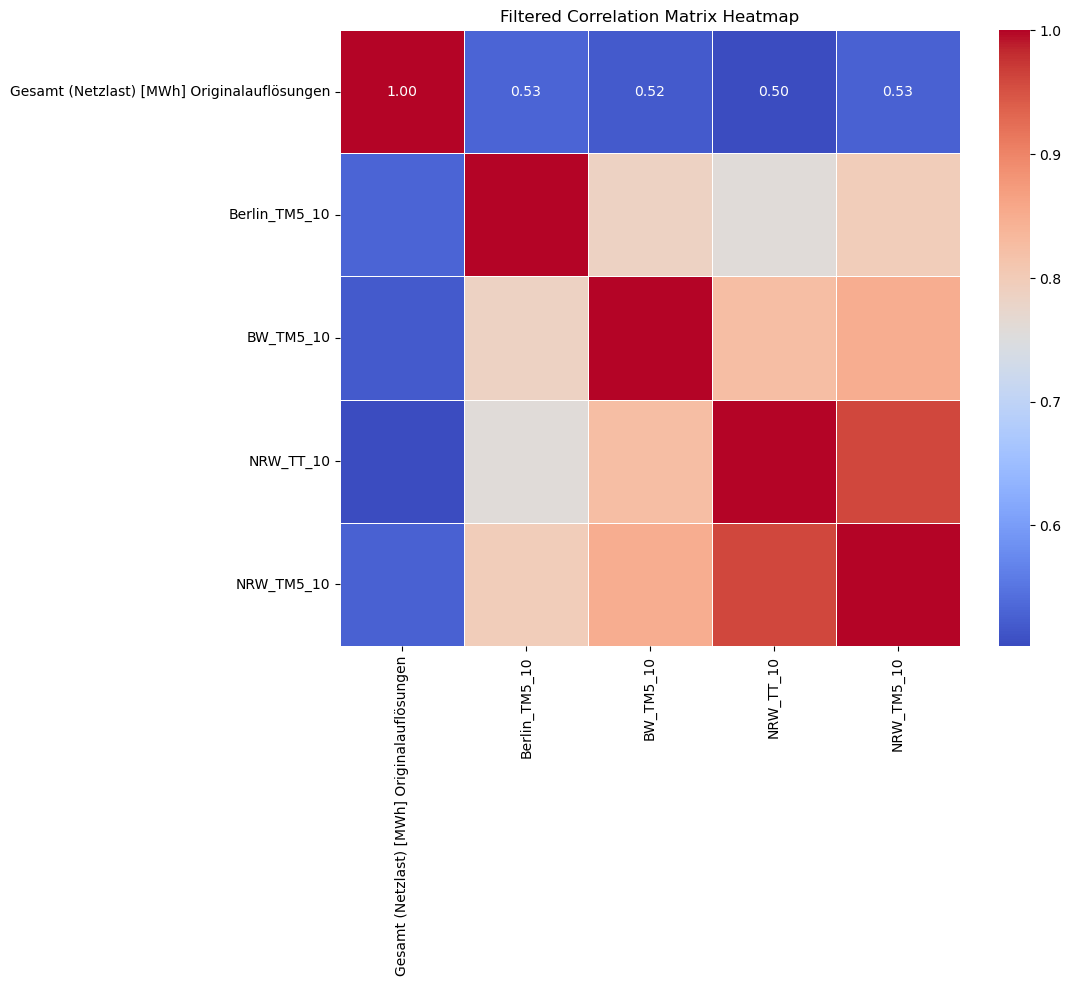

done


In [16]:
categorical_columns = ["Land1", "Land2", "Land3", "Land4", "Runde", "Liga", "DateTime"]
cut_off_limit = 0.5
#print(endresult_df)
#endresult_df.set_index("DateTime")
corr_df_input = endresult_df.copy()
df_filtered = correlation_matrix(corr_df_input, categorical_columns, cut_off_limit)
print("done")

## 2.2 Reducing dimensionality

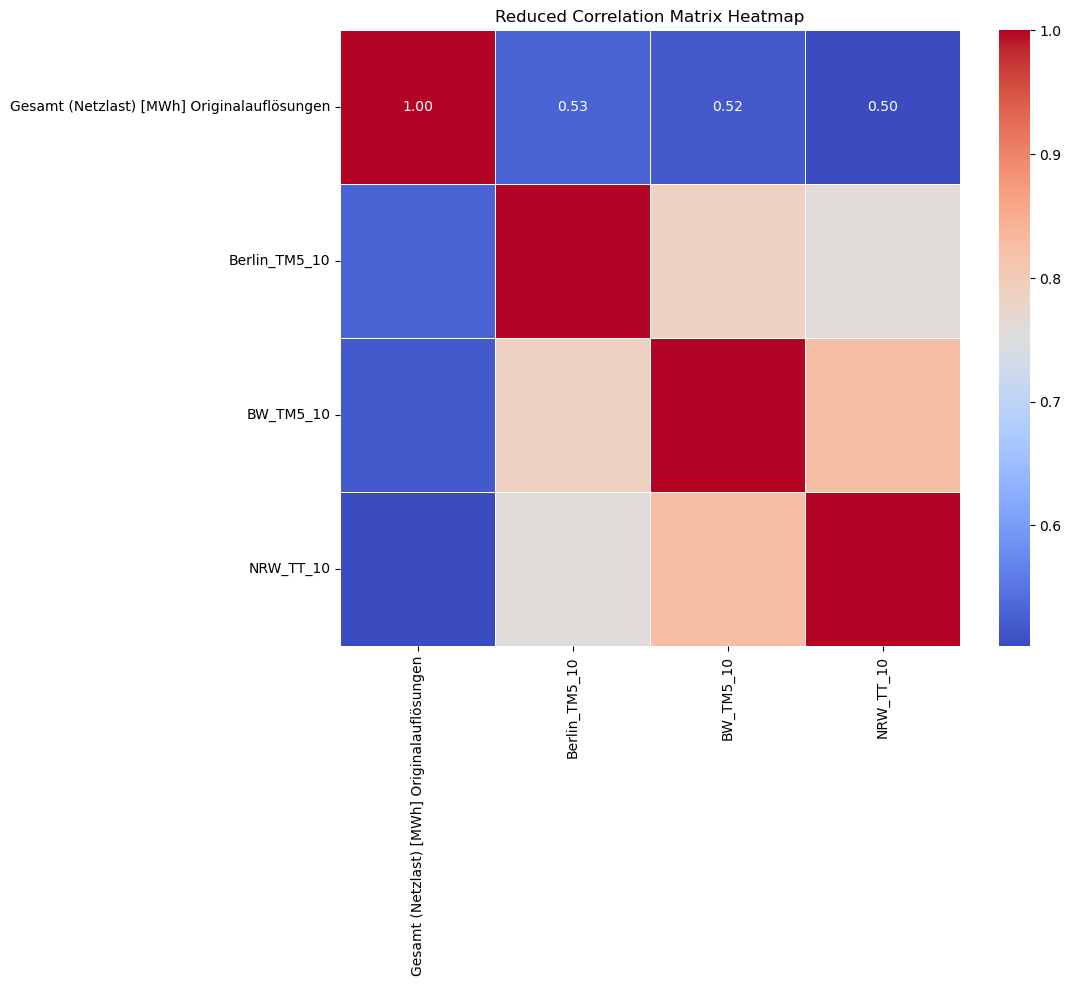

       Gesamt (Netzlast) [MWh] Originalauflösungen            DateTime Land1  \
0                                         11930.50 2016-06-10 00:00:00   NaN   
1                                         11764.50 2016-06-10 00:15:00   NaN   
2                                         11602.50 2016-06-10 00:30:00   NaN   
3                                         11495.00 2016-06-10 00:45:00   NaN   
4                                         11384.25 2016-06-10 01:00:00   NaN   
...                                            ...                 ...   ...   
11323                                     12360.75 2024-07-11 22:45:00   NaN   
11324                                     12261.50 2024-07-11 23:00:00   NaN   
11325                                     12147.25 2024-07-11 23:15:00   NaN   
11326                                     11892.75 2024-07-11 23:30:00   NaN   
11327                                     11718.75 2024-07-11 23:45:00   NaN   

      Land2 Runde Liga Land3 Land4  Ber

In [17]:
# Set the correlation threshold
correlation_threshold = 0.9 # Adjust this threshold as needed
categorical_columns = ["Land1", "Land2", "Land3", "Land4", "Runde", "Liga", "DateTime"]
#print(df_filtered)
reduce_input_df = df_filtered.copy()
df_reduced = reducing_dimensionality(df_filtered, correlation_threshold,categorical_columns)

print("done")

## 2.3 Normalizing Data 

In [18]:
categorical_columns = ["Land1", "Land2", "Land3", "Land4", "Runde", "Liga", "DateTime"]

columns_to_normalize = [col for col in df_reduced.columns if not any(excl in col for excl in categorical_columns)]
scaler = MinMaxScaler()
# Scale the entire dataframe
df_normalized = df_reduced.copy()
df_normalized[columns_to_normalize] = scaler.fit_transform(df_normalized[columns_to_normalize])



print("done")


done



## 2.4 Extracting Features out of DateTime

In [59]:
df_time_feature = df_normalized.copy()


df_time_feature['year'] = df_time_feature['DateTime'].dt.year
df_time_feature['month'] = df_time_feature['DateTime'].dt.month
df_time_feature['day'] = df_time_feature['DateTime'].dt.day
df_time_feature['hour'] = df_time_feature['DateTime'].dt.hour
df_time_feature['minute'] = df_time_feature['DateTime'].dt.minute
df_time_feature['day_of_week'] = df_time_feature['DateTime'].dt.dayofweek
df_time_feature['week_of_year'] = df_time_feature['DateTime'].dt.isocalendar().week
df_time_feature['is_weekend'] = df_time_feature['DateTime'].dt.weekday.apply(lambda x: 1 if x >= 5 else 0)

df_2024_datetime = df_time_feature[df_time_feature['year'] == 2024]
df_2024_datetime = df_2024_datetime["DateTime"]

df_time_feature.drop(columns = ["DateTime"], inplace = True)



print(df_2024_datetime)

# Drop original datetime if you won't need it
print("done")

9024    2024-06-18 00:00:00
9025    2024-06-18 00:15:00
9026    2024-06-18 00:30:00
9027    2024-06-18 00:45:00
9028    2024-06-18 01:00:00
                ...        
11323   2024-07-11 22:45:00
11324   2024-07-11 23:00:00
11325   2024-07-11 23:15:00
11326   2024-07-11 23:30:00
11327   2024-07-11 23:45:00
Name: DateTime, Length: 2304, dtype: datetime64[ns]
done


## 2.5 Encoding categorical values

### 2.5.1 One-Hot Encoding

In [21]:
hot_encoded_df = df_time_feature.copy()
categorical_columns = ["Runde", "Liga"]
hot_encoded_df = pd.get_dummies(hot_encoded_df, columns = categorical_columns)
print("done")

done


### 2.5.2 Ordinal Encoding

In [22]:
#print(football_dic)

temp_path =r"Spielplan"
file_name = "*.csv"
date_column = "DateTime"
date_format = '%d. %b %y %H:%M'
other_date_format = '%d.%m.%Y %H:%M'

football_dic_copy = importing_football_data(temp_path, file_name, date_column, date_format, other_date_format)

country_to_rank = ranking_countries_by_viewership(football_dic_copy)

encoding_columns = ["Land1", "Land2", "Land3", "Land4"]

ordinal_encoded_df = hot_encoded_df.copy()
for column in encoding_columns:
    ordinal_encoded_df[f'{column}_rank'] = ordinal_encoded_df[column].map(country_to_rank)
    
print(ordinal_encoded_df.columns)

df_encoded = ordinal_encoded_df.drop(columns= encoding_columns)
print(len(df_encoded.columns))

df_2024 = df_encoded[df_encoded['year'] == 2024]
deviation_factor = 0.05  # 5% deviation

# Apply Gaussian noise to each value
# The noise will have mean 0 and standard deviation = deviation_factor * actual value
#df_predictions = df_2024.apply(lambda x: x + np.random.normal(0, deviation_factor * x))
# Optionally, create another DataFrame that contains the rows where 'year' is not 2024
df_not_2024 = df_encoded[df_encoded['year'] != 2024]

#print(df_2024)
print(df_not_2024.columns)

Index(['Gesamt (Netzlast) [MWh] Originalauflösungen', 'Land1', 'Land2',
       'Land3', 'Land4', 'Berlin_TM5_10', 'BW_TM5_10', 'NRW_TT_10', 'year',
       'month', 'day', 'hour', 'minute', 'day_of_week', 'week_of_year',
       'is_weekend', 'Runde_Achtelfinale', 'Runde_Finale',
       'Runde_Gruppenphase', 'Runde_Halbfinale', 'Runde_Spiel um Platz 3',
       'Runde_Viertelfinale', 'Liga_EM', 'Liga_WM', 'Land1_rank', 'Land2_rank',
       'Land3_rank', 'Land4_rank'],
      dtype='object')
24
Index(['Gesamt (Netzlast) [MWh] Originalauflösungen', 'Berlin_TM5_10',
       'BW_TM5_10', 'NRW_TT_10', 'year', 'month', 'day', 'hour', 'minute',
       'day_of_week', 'week_of_year', 'is_weekend', 'Runde_Achtelfinale',
       'Runde_Finale', 'Runde_Gruppenphase', 'Runde_Halbfinale',
       'Runde_Spiel um Platz 3', 'Runde_Viertelfinale', 'Liga_EM', 'Liga_WM',
       'Land1_rank', 'Land2_rank', 'Land3_rank', 'Land4_rank'],
      dtype='object')


### 2.5.3 Cyclic Encoding

In [65]:

categorical_columns = ["Land1", "Land2", "Land3", "Land4", "Runde", "Liga", "DateTime"]
columns_to_normalize = ["year", 'week_of_year', 'month' ]

df_normalized_cyclic = cyclic_encoding(df_not_2024, categorical_columns, columns_to_normalize)
df_normalized_cyclic.fillna(0, inplace=True)

print(df_normalized_cyclic.columns)

Index(['Gesamt (Netzlast) [MWh] Originalauflösungen', 'Berlin_TM5_10',
       'BW_TM5_10', 'NRW_TT_10', 'year', 'month', 'week_of_year', 'is_weekend',
       'Runde_Achtelfinale', 'Runde_Finale', 'Runde_Gruppenphase',
       'Runde_Halbfinale', 'Runde_Spiel um Platz 3', 'Runde_Viertelfinale',
       'Liga_EM', 'Liga_WM', 'Land1_rank', 'Land2_rank', 'Land3_rank',
       'Land4_rank', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos',
       'minute_sin', 'minute_cos', 'day_of_week_sin', 'day_of_week_cos'],
      dtype='object')


# 3. Modelling

In [54]:
%run Modelling.ipynb

## 3.1 Linear Regression

Train index: 1503, Test index: 3007
Mean Squared Error: 1.0366450083244276
R^2 Score: -15.474182874795083
Train index: 3007, Test index: 4511
Mean Squared Error: 0.027998568875413236
R^2 Score: 0.5605127858989636
Train index: 4511, Test index: 6015
Mean Squared Error: 0.02101341058882232
R^2 Score: 0.6621996997378279
Train index: 6015, Test index: 7519
Mean Squared Error: 0.015050824269454326
R^2 Score: 0.701046000320729
Train index: 7519, Test index: 9023
Mean Squared Error: 0.014704712164937149
R^2 Score: 0.7363411344531008
Average Mean Squared Error: 0.22308250484461087
Average R^2 Score: -2.5628166508768926


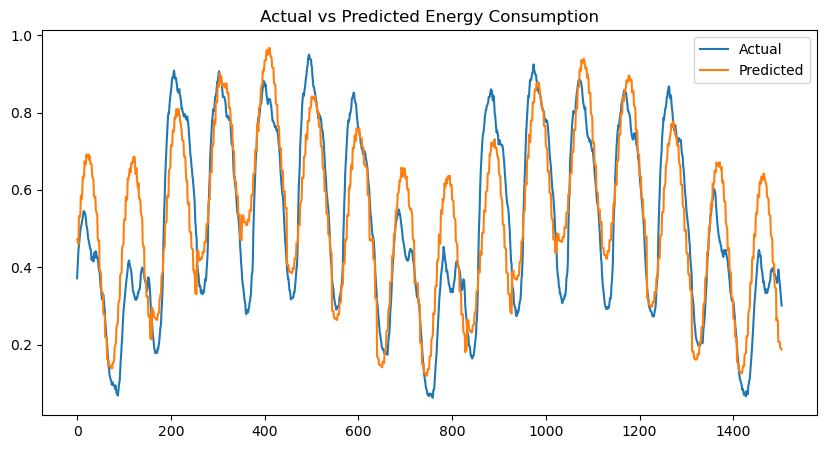

In [37]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt



X = df_normalized_cyclic[['Berlin_TM5_10',
       'BW_TM5_10', 'NRW_TT_10', 'year', 'month', 'week_of_year',
       'Runde_Achtelfinale', 'Runde_Finale', 'Runde_Gruppenphase',
       'Runde_Halbfinale', 'Runde_Spiel um Platz 3', 'Runde_Viertelfinale',
       'Liga_EM', 'Liga_WM', 'Land1_rank', 'Land2_rank', 'Land3_rank',
       'Land4_rank', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos',
       'minute_sin', 'minute_cos', 'day_of_week_sin', 'day_of_week_cos']]

y = df_normalized_cyclic['Gesamt (Netzlast) [MWh] Originalauflösungen']
X = X.fillna(0)

mse_scores = []
r2_scores = []

# Zeitreihenaufteilung mit TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
model = LinearRegression()

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Modell trainieren
    model.fit(X_train, y_train)
    
    # Vorhersage
    y_pred = model.predict(X_test)
    
    # Bewertung
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    mse_scores.append(mse)
    r2_scores.append(r2)
    
    print(f"Train index: {train_index[-1]}, Test index: {test_index[-1]}")
    print(f"Mean Squared Error: {mse}")
    print(f"R^2 Score: {r2}")

print(f"Average Mean Squared Error: {np.mean(mse_scores)}")
print(f"Average R^2 Score: {np.mean(r2_scores)}")

# Visualisierung der letzten Vorhersage
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label="Actual")
plt.plot(y_pred, label="Predicted")
plt.legend()
plt.title("Actual vs Predicted Energy Consumption")
plt.show()

## 3.2 Random Forest

Train index: 1503, Test index: 3007
Mean Squared Error: 0.0011668723751011437
R^2 Score: 0.9814562663741235
Train index: 3007, Test index: 4511
Mean Squared Error: 0.001998694000294415
R^2 Score: 0.968626951543898
Train index: 4511, Test index: 6015
Mean Squared Error: 0.0012049797067972738
R^2 Score: 0.980629393546307
Train index: 6015, Test index: 7519
Mean Squared Error: 0.002782991456216082
R^2 Score: 0.9447215373713748
Train index: 7519, Test index: 9023
Mean Squared Error: 0.001530219424152166
R^2 Score: 0.9725628143628805
Average Mean Squared Error: 0.001736751392512216
Average R^2 Score: 0.9695993926397168


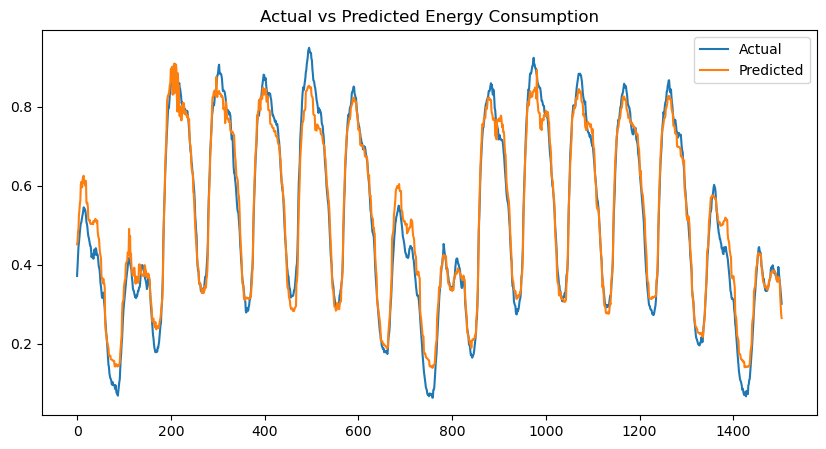

In [38]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Angenommen, df_encoded ist bereits vorverarbeitet und kodiert
# Beispiel: df_encoded laden
# df_encoded = pd.read_csv("df_encoded.csv")

# Zielvariable und Features definieren
X = df_normalized_cyclic[['Berlin_TM5_10',
       'BW_TM5_10', 'NRW_TT_10', 'year', 'month', 'week_of_year',
       'Runde_Achtelfinale', 'Runde_Finale', 'Runde_Gruppenphase',
       'Runde_Halbfinale', 'Runde_Spiel um Platz 3', 'Runde_Viertelfinale',
       'Liga_EM', 'Liga_WM', 'Land1_rank', 'Land2_rank', 'Land3_rank',
       'Land4_rank', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos',
       'minute_sin', 'minute_cos', 'day_of_week_sin', 'day_of_week_cos']]
y = df_normalized_cyclic['Gesamt (Netzlast) [MWh] Originalauflösungen']

# Fehlende Werte durch Null ersetzen
X = X.fillna(0)

mse_scores = []
r2_scores = []

# Zeitreihenaufteilung mit TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
model = RandomForestRegressor(n_estimators=100, random_state=42)

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Modell trainieren
    model.fit(X_train, y_train)
    
    # Vorhersage
    y_pred = model.predict(X_test)
    
    # Bewertung
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    mse_scores.append(mse)
    r2_scores.append(r2)
    
    print(f"Train index: {train_index[-1]}, Test index: {test_index[-1]}")
    print(f"Mean Squared Error: {mse}")
    print(f"R^2 Score: {r2}")

print(f"Average Mean Squared Error: {np.mean(mse_scores)}")
print(f"Average R^2 Score: {np.mean(r2_scores)}")

# Visualisierung der letzten Vorhersage
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label="Actual")
plt.plot(y_pred, label="Predicted")
plt.legend()
plt.title("Actual vs Predicted Energy Consumption")
plt.show()


In [ ]:
##EM 2024 Deutschland

df_new = pd.DataFrame(new_data)

# Vorhersagen für neue Daten
y_pred_new = model.predict(df_new)

# Anzeigen der Vorhersagen
print(y_pred_new)

## 3.3 LSTM

### 3.3.1 Datentypen für LSTM anpassen

In [73]:

bool_columns = ['Runde_Achtelfinale', 'Runde_Finale', 'Runde_Gruppenphase',
                'Runde_Halbfinale', 'Runde_Spiel um Platz 3', 'Runde_Viertelfinale',
                'Liga_EM', 'Liga_WM']

df_normalized_cyclic[bool_columns] = df_normalized_cyclic[bool_columns].astype(int)

float_columns = ['Gesamt (Netzlast) [MWh] Originalauflösungen', 'Berlin_TM5_10', 'BW_TM5_10',
                  'NRW_TT_10', 'Land1_rank', 'Land2_rank', 'Land3_rank', 'Land4_rank']

df_normalized_cyclic[float_columns] = df_normalized_cyclic[float_columns].astype(np.float32)

int_columns = ['year','hour_sin','hour_cos', 'minute_sin', 'minute_cos', 'day_of_week_sin',
               'day_of_week_cos',"is_weekend", 'Runde_Achtelfinale', 'Runde_Finale', 'Runde_Gruppenphase', 'Runde_Halbfinale',
               'Runde_Spiel um Platz 3', 'Runde_Viertelfinale', 'Liga_EM', 'Liga_WM']

df_normalized_cyclic[int_columns] = df_normalized_cyclic[int_columns].astype(np.int32)

### 3.3.2 Dataframe in Sequenzen und Tensor umwandeln

In [46]:

target_column = 'Gesamt (Netzlast) [MWh] Originalauflösungen'

# Separate features and target
X = df_normalized_cyclic.drop(columns=[target_column])
y = df_normalized_cyclic[target_column]

sequence_length = 96

# Create sequences
X_sequences, y_sequences = create_sequences(X.values, y.values, sequence_length)

# Reshape X for LSTM: [samples, time steps, features]
num_features = X_sequences.shape[2]  # Number of features
X_sequences = X_sequences.reshape((X_sequences.shape[0], X_sequences.shape[1], num_features))

print(f'X_sequences shape: {X_sequences.shape}')
print(f'y_sequences shape: {y_sequences.shape}')


X_sequences shape: (8928, 96, 27)
y_sequences shape: (8928,)


### 3.3.3 Festlegung der Modellarchitektur

In [48]:
layers = 32
epochs = 20
regularization = 0.001
dropout = 0.3
learning_rate = 0.0005
early_stopping = 5

### 3.3.4 Train und Test Split mit Validierung

Epoch 1/20


C:\Users\Isabell\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 14s 88ms/step - loss: 0.2961 - val_loss: 0.1636
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step - loss: 0.1309 - val_loss: 0.1474
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - loss: 0.1069 - val_loss: 0.1273
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - loss: 0.0891 - val_loss: 0.1092
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - loss: 0.0771 - val_loss: 0.1083
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - loss: 0.0668 - val_loss: 0.0877
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - loss: 0.0587 - val_loss: 0.0899
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - loss: 0.0515 - val_loss: 0.0797
Epoch 9/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - loss: 0.0474 - val_loss: 0.0739
Epoch 10/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - loss: 0.0423 - val_loss: 0.0725
Epoch 11/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - loss: 0.0385 - val_loss: 0.0627
Epoch 12/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - loss: 0.0347 - va

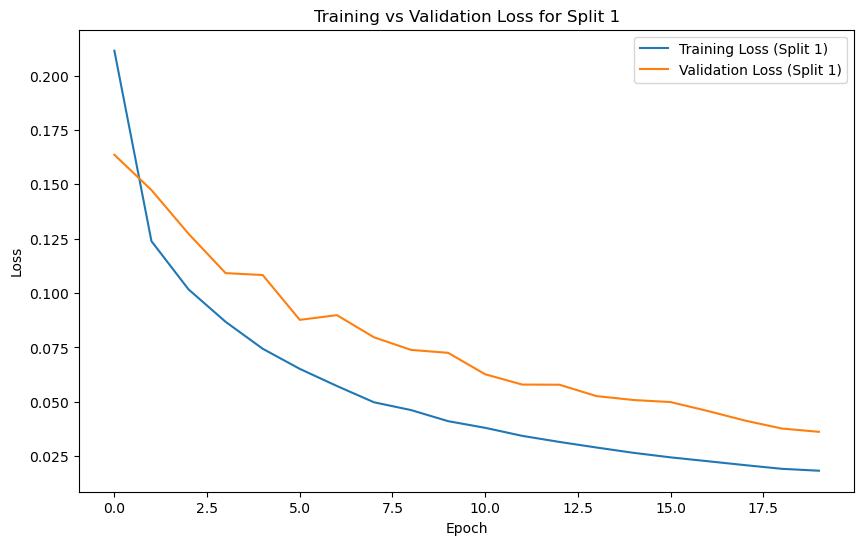

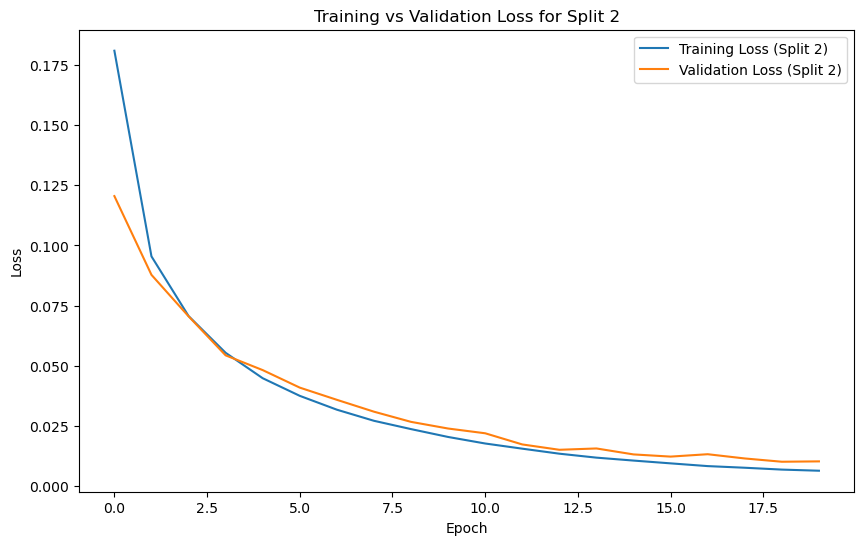

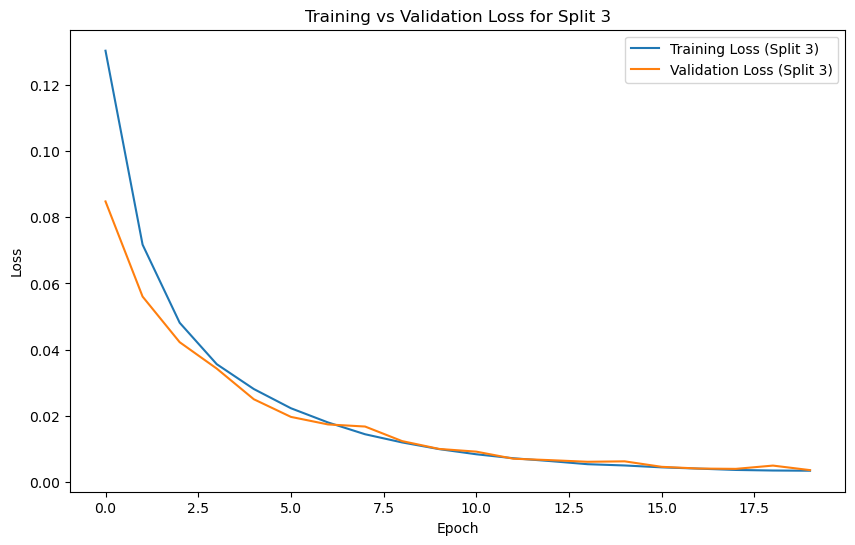

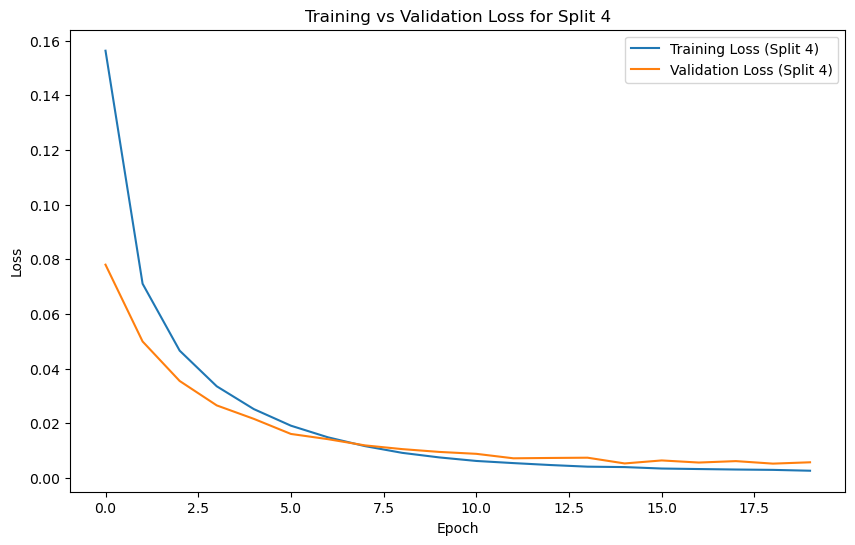

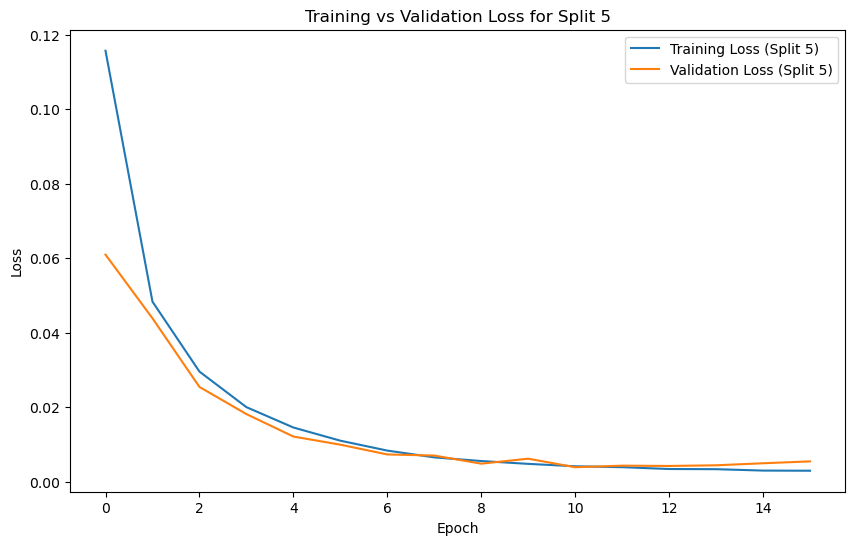

In [49]:
tscv = TimeSeriesSplit(n_splits=5)
split_results = []

train_losses_per_split = []
val_losses_per_split = []

for train_index, test_index in tscv.split(X_sequences):

    X_train, X_test = X_sequences[train_index], X_sequences[test_index]
    y_train, y_test = y_sequences[train_index], y_sequences[test_index]


    history,model = lstm_model(X_train, X_test,y_train, y_test, layers, epochs, regularization, dropout, learning_rate, early_stopping)
    
    # Evaluate the model
    # Collect loss for plotting
    train_losses_per_split.append(history.history['loss'])
    val_losses_per_split.append(history.history['val_loss'])
    
    loss = model.evaluate(X_test, y_test)
    split_results.append(loss)

# Average performance over all splits
average_loss = np.mean(split_results)
print(f'Average validation loss over all splits: {average_loss}')

# Plot training and validation losses across splits
for i in range(len(train_losses_per_split)):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses_per_split[i], label=f'Training Loss (Split {i+1})')
    plt.plot(val_losses_per_split[i], label=f'Validation Loss (Split {i+1})')
    plt.title(f'Training vs Validation Loss for Split {i+1}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

### 3.3.5 Finales Model

C:\Users\Isabell\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 34s 68ms/step - loss: 0.1698 - val_loss: 0.0685
Epoch 2/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 38s 61ms/step - loss: 0.0589 - val_loss: 0.0386
Epoch 3/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 44s 68ms/step - loss: 0.0342 - val_loss: 0.0246
Epoch 4/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 25s 63ms/step - loss: 0.0229 - val_loss: 0.0167
Epoch 5/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 25s 61ms/step - loss: 0.0161 - val_loss: 0.0121
Epoch 6/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 25s 62ms/step - loss: 0.0115 - val_loss: 0.0095
Epoch 7/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 25s 61ms/step - loss: 0.0086 - val_loss: 0.0068
Epoch 8/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 25s 63ms/step - loss: 0.0067 - val_loss: 0.0050
Epoch 9/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 25s 63ms/step - loss: 0.0057 - val_loss: 0.0043
Epoch 10/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 40s 61ms/step - loss: 0.0047 - val_loss: 0.0047
Epoch 11/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 25s 63ms/step - loss: 0.0043 - val_loss: 0.0034
Epoch 12/20
402/402 ━━━━━━━━━━

Text(0, 0.5, 'Value')

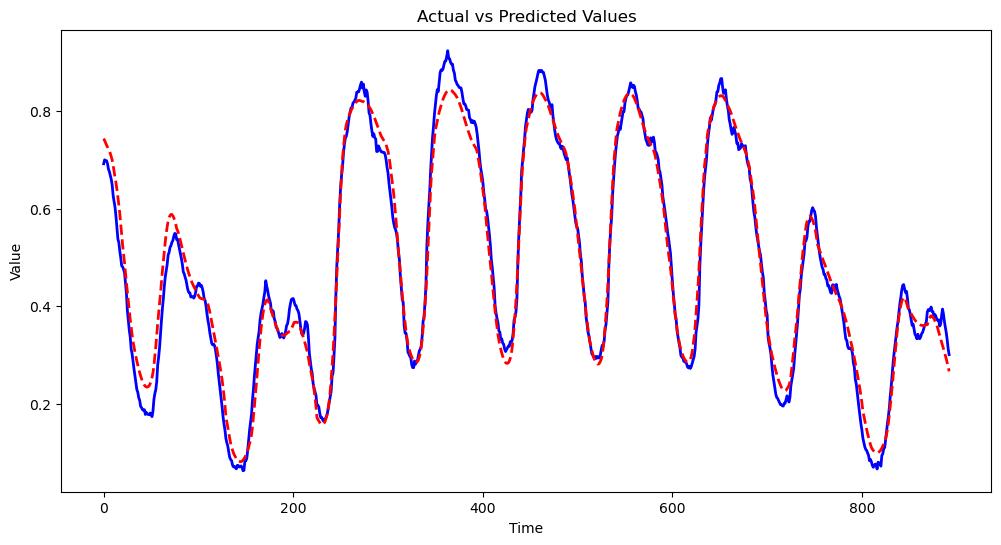

In [55]:

# Assuming the model performed well, we now train on the entire dataset (except the final test set)
train_size = int(len(X_sequences) * 0.9)
X_train_final, X_test_final = X_sequences[:train_size], X_sequences[train_size:]
y_train_final, y_test_final = y_sequences[:train_size], y_sequences[train_size:]


lstm_final, model_final = lstm_model(X_train_final, X_test_final,y_train_final, y_test_final, layers, epochs, regularization, dropout, learning_rate, early_stopping)


# Final evaluation
final_loss = model_final.evaluate(X_test_final, y_test_final)
print(f'Final test loss: {final_loss}')

y_pred = model_final.predict(X_test_final)
r2 = r2_score(y_test_final, y_pred)

print(f'R² Score: {r2}')

# Plotting actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test_final, label='Actual Values', color='blue', linewidth=2)
plt.plot(y_pred, label='Predicted Values', color='red', linewidth=2, linestyle='--')
plt.title('Actual vs Predicted Values')
plt.legen()
plt.xlabel('Time')
plt.ylabel('Value')


### 3.3.6 Vorhersage der EM 2024 

In [86]:
target_column = 'Gesamt (Netzlast) [MWh] Originalauflösungen'

# Separate features and target
print(df_normalized_cyclic)
X = df_normalized_cyclic.drop(columns=[target_column])
y = df_normalized_cyclic[target_column]

sequence_length = 96

# Create sequences
X_sequences, y_sequences = create_sequences(X.values, y.values, sequence_length)
print(X_sequences)

num_features = X.shape[2]  # Number of features
X_sequences = X_sequences.reshape((X_sequences.shape[0], X_sequences.shape[1], num_features))

print(f'X_sequences shape: {X_sequences.shape}')
#print(f'y_sequences shape: {y_sequences.shape}')

y_pred_2024 = model_final.predict(X_sequences)

print("done")

       Gesamt (Netzlast) [MWh] Originalauflösungen  Berlin_TM5_10  BW_TM5_10  \
9024                                      0.256774       0.235294   0.174923   
9025                                      0.250488       0.235294   0.164087   
9026                                      0.243380       0.233032   0.159443   
9027                                      0.240891       0.219457   0.145511   
9028                                      0.212537       0.219457   0.156347   
...                                            ...            ...        ...   
11323                                     0.388227       0.416290   0.334365   
11324                                     0.378041       0.386878   0.335913   
11325                                     0.366314       0.371041   0.331269   
11326                                     0.340193       0.365385   0.334365   
11327                                     0.322334       0.361991   0.334365   

       NRW_TT_10  year  month  week_of_

IndexError: tuple index out of range

9024    2024-06-18 00:00:00
9025    2024-06-18 00:15:00
9026    2024-06-18 00:30:00
9027    2024-06-18 00:45:00
9028    2024-06-18 01:00:00
                ...        
11323   2024-07-11 22:45:00
11324   2024-07-11 23:00:00
11325   2024-07-11 23:15:00
11326   2024-07-11 23:30:00
11327   2024-07-11 23:45:00
Name: DateTime, Length: 2304, dtype: datetime64[ns]
[0.28615415 0.2724007  0.26621678 ... 0.36631426 0.34019297 0.322334  ]


Text(0, 0.5, 'Value')

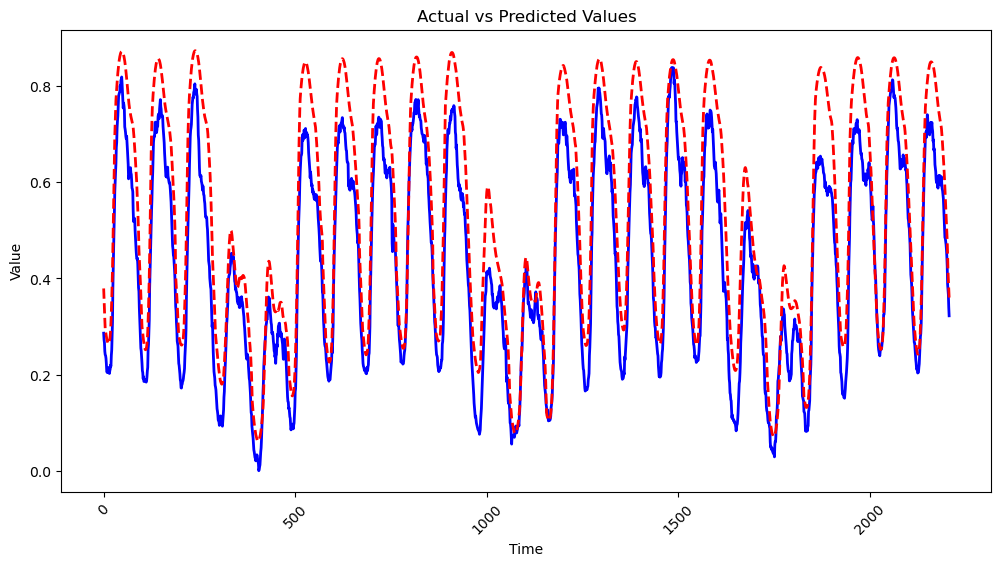

In [87]:
plt.figure(figsize=(12, 6))
print(df_2024_datetime)
print(y_sequences)
plt.plot(y_sequences, label='Actual Values', color='blue', linewidth=2)
plt.plot(y_pred_2024, label='Predicted Values', color='red', linewidth=2, linestyle='--')
plt.title('Actual vs Predicted Values')

plt.xticks(rotation=45) 
plt.xlabel('Time')
plt.ylabel('Value')
